In [104]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import ttest_ind
import networkx as nx

In [39]:
dataset = torch.load('nfl_coaches_subset.pt', weights_only=False)

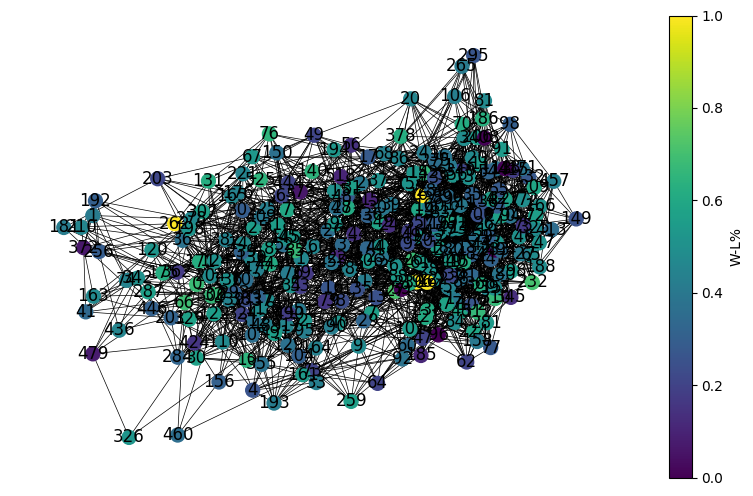

In [113]:
edges = dataset.edge_index.t().numpy()
G = nx.Graph()
G.add_edges_from(edges)

fig, ax = plt.subplots(figsize=(10,6))

pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax,
        node_color=dataset.x[:,4],
        node_size=100,
        width=0.5,
        with_labels=True,
        cmap=plt.cm.viridis)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=dataset.x[:,4].min(), vmax=dataset.x[:,4].max()))
plt.colorbar(sm, ax=ax, label='W-L%')

plt.show()


In [137]:
class ChebGNN(nn.Module):
    def __init__(self, in_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, 32, K=K)
        self.conv2 = ChebConv(32, 16, K=K)
        self.lin = nn.Linear(16, 1)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        out = self.lin(x)
        return out.squeeze()
    
class GCN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Linear(in_channels, 32)
        self.conv2 = torch.nn.Linear(32, 16) 
        self.lin = nn.Linear(16, 1)
        
    def forward(self, x, edge_index):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        out = self.lin(x)
        return out.squeeze()

## mad data leakage in this bih

In [186]:
def run_experiment(dataset, model, feature_name='W-L%', train_ratio=0.6, val_ratio=0.2, plot=False, verbose = False):

    X = dataset.x.numpy()

    feature_names = ['Yrs', 'G', 'W', 'T', 'W-L%', 'G > .500', 'AvRk', 'BstRk', 'HOF']
    feature_idx = feature_names.index(feature_name)
    
    # Create a tensor of ones as the only feature
    # X = torch.ones((dataset.x.shape[0], 1), dtype=torch.float)
    X = torch.tensor(X[:,feature_idx].reshape(-1,1))
    edge_index = dataset.edge_index
    
    # idk why i gotta do this but sometimes an error otherwise
    # I think its cause the sub dataset i took out the nodes of coaches < 10 degrees but the edge index is still has stuff
    max_node_idx = X.shape[0] - 1
    edge_index = edge_index[:, (edge_index[0] <= max_node_idx) & (edge_index[1] <= max_node_idx)]

    # Train/test/val
    num_nodes = X.shape[0]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)

    indices = torch.randperm(num_nodes)
    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size+val_size]] = True 
    test_mask[indices[train_size+val_size:]] = True

    if verbose:
        print(f"Train size: {train_mask.sum().item()}, Val size: {val_mask.sum().item()}, Test size: {test_mask.sum().item()}")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    y = dataset.x[:,feature_idx]

    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(X, edge_index)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            val_out = model(X, edge_index)
            val_loss = criterion(val_out[val_mask], y[val_mask])
            val_losses.append(val_loss.item())
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    if plot:
        plt.figure(figsize=(10,6))
        plt.subplot(1,1,1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Structure-only prediction of {feature_name}')
        plt.legend()

    model.eval()
    with torch.no_grad():
        out = model(X, edge_index)
        y_pred = out[test_mask].numpy()
        y_true = y[test_mask].numpy()
        # print(y_true)
        # print(y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        p_value = ttest_ind(y_true, y_pred, alternative='greater').pvalue
        
        if plot:
            plt.figure(figsize=(10,6))
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            plt.xlabel('Actual ' + feature_name )
            plt.ylabel('Predicted ' + feature_name)
            plt.title('Actual vs Predicted ' + feature_name + ' on Test Set (Structure Only)')
            plt.tight_layout()
            plt.show()
        
        if verbose:
            print(f"Test Set Evaluation for {feature_name}:")
            print(f"Mean Squared Error: {mse:.4f}")
            print(f"r2 Score: {r2:.4f}")
            
            print("Sample Predictions:")
            print("Actual\tPredicted")
            for actual, pred in zip(y_true[:5], y_pred[:5]):
                print(f"{actual:.3f}\t{pred:.3f}")
            
        return mse, r2, p_value


torch.Size([280, 9])
Train size: 168, Val size: 56, Test size: 56
Early stopping at epoch 145


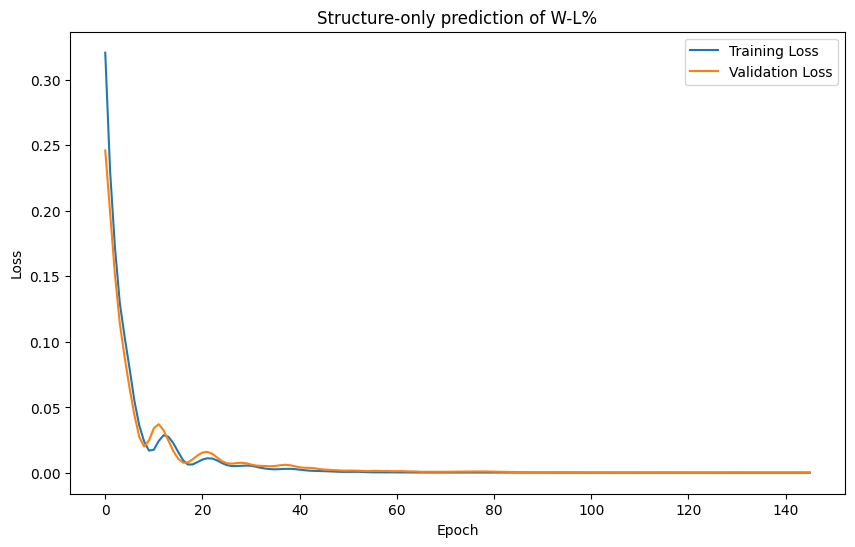

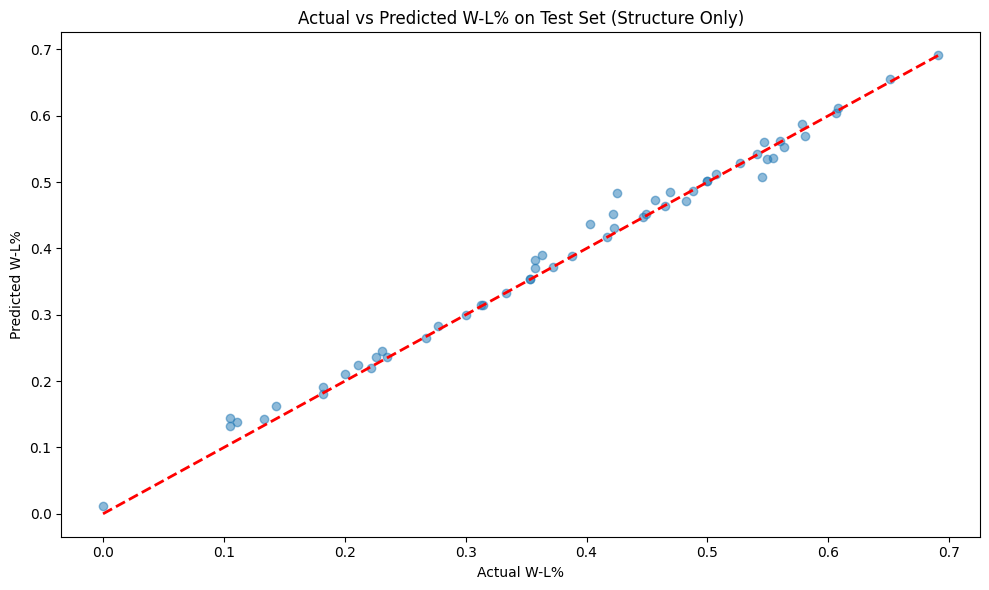

Test Set Evaluation for W-L%:
Mean Squared Error: 0.0003
r2 Score: 0.9899
Sample Predictions:
Actual	Predicted
0.691	0.691
0.447	0.448
0.313	0.314
0.200	0.211
0.235	0.236


(0.00026020529912784696, 0.9899060726165771, 0.5863435334187109)

In [187]:
model = ChebGNN(1)

print(dataset.x.shape)
run_experiment(dataset, model, feature_name='W-L%', train_ratio=0.6, val_ratio=0.2, plot=True, verbose=True)

In [188]:
model = ChebGNN(1)
mse_list = []
r2_list = []
p_value_list = []
for i in range(10): 
    mse, r2, p_value= run_experiment(dataset, model, feature_name='W-L%', train_ratio=0.6, val_ratio=0.2)
    mse_list.append(mse)
    r2_list.append(r2)
    p_value_list.append(p_value)

# I forgot what p val and r2 are but I printed them anyway
# pval looks bad but r2 is good so idk 
print(f"Mean MSE: {np.mean(mse_list):.4f}, Std MSE: {np.std(mse_list):.4f}")
print(f"Mean R2: {np.mean(r2_list):.4f}, Std R2: {np.std(r2_list):.4f}")
print(f"Mean P-value: {np.mean(p_value_list):.4f}, Std P-value: {np.std(p_value_list):.4f}")

Mean MSE: 0.0012, Std MSE: 0.0009
Mean R2: 0.9569, Std R2: 0.0400
Mean P-value: 0.4705, Std P-value: 0.0979
